In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
#torchinfo package help to visual representation of model
try:
  from torchinfo import summary
except:
  print("[info] couldn't find torchinfo .... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary
  

[info] couldn't find torchinfo .... installing it.


In [ ]:
# try to import going_modular directory, if not available, download it from github
try:
  from going_modular import data_setup, engine
except:
  print("[info] couldn't find going_modular scripts... downloading them from github.")
  !git clone https://github.com/zim10/Deep-learning-using-pytorch.git
  !mv Deep-learning-using-pytorch/going_modular going_modular
  !rm -rf Deep-learning-using-pytorch #remove folder
  from going_modular import data_setup, engine

[info] couldn't find going_modular scripts... downloading them from github.
Cloning into 'Deep-learning-using-pytorch'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 91 (delta 32), reused 32 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), 37.92 MiB | 7.68 MiB/s, done.


In [ ]:
#!git --version
#!rm -rf Dive-into-deep-learning

In [ ]:
#get data
import os
import zipfile
from pathlib import Path
import requests
data_path = Path("data/")
image_path = data_path /"pizza_steak_sushi"
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one....")
  image_path.mkdir(parents=True, exist_ok = True)

  #Downloading pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("downloading pizza, steak, sushi data....")
    f.write(request.content)
  #unzip
  with zipfile.ZipFile(data_path /"pizza_steak_sushi.zip", "r" ) as zip_ref:
    print("unzipping")
    zip_ref.extractall(image_path)



Did not find data/pizza_steak_sushi directory, creating one....
downloading pizza, steak, sushi data....
unzipping


In [ ]:
!python going_modular/get_data.py

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...


In [ ]:
train_dir = image_path /"train"
test_dir = image_path /"test"

In [ ]:
#create a manual transforms using compose
from torchvision import transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std= [0.229, 0.224, 0.225])
])

In [ ]:
#create a train and test data loader using manual_transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f27561896a0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
#get a pretrainded models weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
#use auto_transforms
#get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#create a tran and test dataloader using autotransforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2756189100>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#now use a pretrained model in pizza-steak-sushi dataset
#setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights = weights).to(device) #new method
#model = torchvision.models.efficientnet_b0(pretrained = True).to(device) #old method

In [ ]:
# getting the summary of model using torchinfo.summary()
summary(model = model_0,
        input_size=(32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

In [ ]:
#freeze all base layers in the features section of the model (the feature extractor) by setting requires_grad=False
#feature extractor layers frozen
for param in model_0.features.parameters():
  param.requires_grad = False

In [ ]:
#adjust output classifier portion of the pretrained model, as it has 1000 classes, but our has 3 classes
#ourr new classifier layer should be
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)
#recreate classifier layer and send to the device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [ ]:
#output layer has updated, lets get another summary of the model
summary(model = model_0,
        input_size=(32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

In [ ]:
#now we got the train model with semi-frozen classifier
#trainmodel
#define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.001)

In [ ]:
#we will train() function which is in the engine.py
# only train the parameters of classifier layer and all of the other parameters in our model have frozen
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
start_time = timer()
#setup training and save result
model_0_results = engine.train(model= model_0,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)
end_time = timer()
print(f"[info] total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5299 | train_acc: 0.9297 | test_loss: 0.5659 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.4778 | train_acc: 0.9258 | test_loss: 0.5202 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.4519 | train_acc: 0.9219 | test_loss: 0.5223 | test_acc: 0.8551
Epoch: 4 | train_loss: 0.4767 | train_acc: 0.8398 | test_loss: 0.4780 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.4071 | train_acc: 0.9609 | test_loss: 0.4914 | test_acc: 0.8561
[info] total training time: 13.058 seconds


In [ ]:
#how to take one .py file (specific file from github repo)
try:
  from helper_functions import plot_loss_curves
except:
  print("[info] couldn't fidn the file, dowloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/zim10/Deep-learning-using-pytorch/main/Deep_learning_exercise/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

[info] couldn't fidn the file, dowloading...


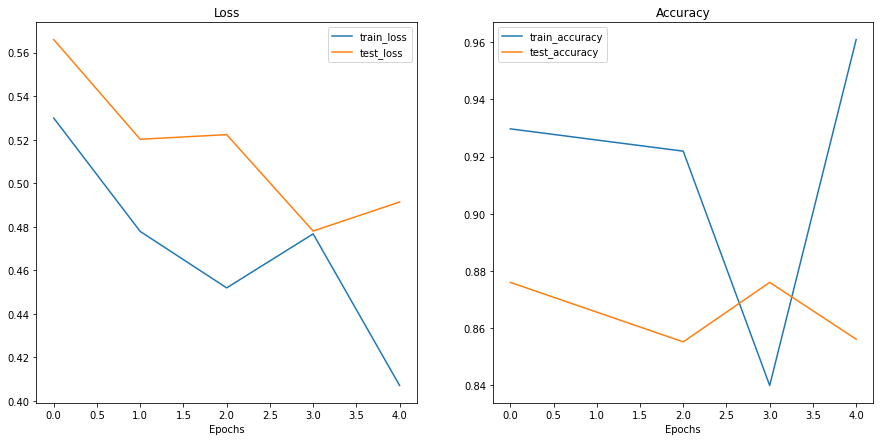

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(model_0_results)

In [ ]:
# make prediction on images from the test dataset
from typing import List, Tuple
from PIL import Image
#1. take a trained model, class names, image path, image size, transform and device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform = None,
                        device: torch.device=device):
  #. 2. open image
  img = Image.open(image_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std = [0.229, 0.224, 0.225]),
    ])
  #4. target decvice
  model.to(device)
  #5. model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    #6. andd an extra dimention
    tranformed_image = image_transform(img).unsqueeze(dim=0)
    #7. make prediction
    target_image_pred = model(tranformed_image.to(device))
    #8. convert logits 
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    #9. convert pred probabilites into labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    #10. plot image with lable and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"pred: {class_names[target_image_pred_label]} | probability: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

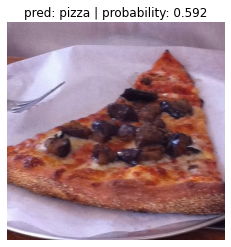

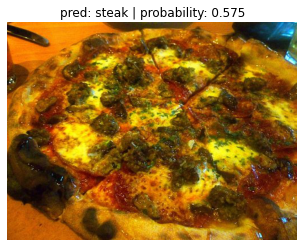

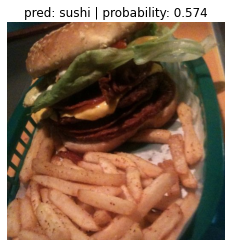

In [ ]:
#get a random list of image path from test directory
#need  glob
import random
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) 
test_image_path_sample = random.sample(population = test_image_path_list, k =3)
#call the above functio
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model_0,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224, 224))

In [ ]:
#custom image load from github
import requests
custom_image_path = data_path / "pizza-3007395__480.jpg"
#download img if it's not in the directory
if not custom_image_path.is_file():
  print("[info] couldn't fidn the file, dowloading...")
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/zim10/Deep-learning-using-pytorch/main/Deep_learning_exercise/pizza-3007395__480.jpg")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exist")

[info] couldn't fidn the file, dowloading...


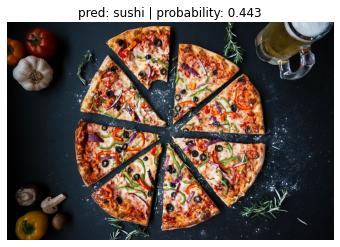

In [ ]:
#predict on custom image
pred_and_plot_image(model = model_0,
                    image_path = custom_image_path,
                    class_names = class_names)

* Transfer learning often allows to you get good results with a relatively small amount of custom data.
* Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?"
* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.
* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.
There are several different places to find pretrained models from the PyTorch domain libraries, HuggingFace Hub and libraries such as timm (PyTorch Image Models).

In [ ]:
#make prediction on the entire test dataset and plot a confusion matrix of the result
#make predctions the entire test dataset
from tqdm.auto import tqdm
test_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    #pass the data through the model
    test_logits = model_0(X)
    #convert the pred logits to pred rpobbs
    pred_probs = torch.softmax(test_logits, dim=1)
    #convert  the pred probs into label 
    pred_labels = torch.argmax(pred_probs,dim=1)
    #add the pred labels to test preds lis
    test_preds.append(pred_labels)
#print(test_preds)
# concatenate the test preds and put them on the cpu
test_preds = torch.cat(test_preds).cpu()
print(test_preds)

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])


In [ ]:
#make a confusion matrix with test preds and the truth labels
#how to get the truth lablel of the test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 11.1 MB/s eta 0:00:00


In [ ]:
#torch matrix and mlxtend lib need for confusion matrix
#how to download and check specific version of a lib
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >=10, "mlxtend version"
except:
  !pip install -q torchmetrics, -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.14.0


In [ ]:
len(class_names)

3

MulticlassConfusionMatrix()


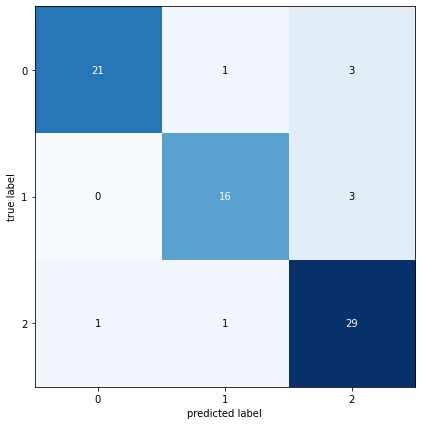

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
#create confusion matrix instance
confmat = ConfusionMatrix(num_classes = len(class_names), task ='multiclass')
print(confmat)
confmat_tensor = confmat(preds = test_preds,
                         target = test_truth)
#confmat_tensor
#plo the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), #matplotlib works with numpy
    #class_names = class_names,
    figsize = (10, 7)
) 

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])
     

After trainig and evaluating a ML model, next task is ask questin to your model and answer it using your model. this is the only way to troobleshoot the model.

**Question can be the following:**
1. where did model predict "most wrong" class? I mean get the "most wrong" of the prediction by model on the test dataset and plot the "most wrong" image. otherwise- **where your model predicted wrong with high prediction probability?**

In [ ]:
#answer:  get the "most wrong " of the predictions on the test dataset and plot "most wrong" image
#create a dataframe with sample , label, prediction, prede prob
#get all the test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
#print(test_data_paths)
test_labels = [path.parent.stem for path in test_data_paths]
#print(len(test_labels)) print(test_labels)
#createa function to return a list of dictionaries with sample, labe
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    #create empty dict to store info for each sample
    pred_dict = {}
    #get sample path
    pred_dict["image_path"] = path

    #get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name
    
    #get prediction and prediction probability
    from PIL import Image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]
      #make sure things in the dictionary 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_label"] = pred_class
    #does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class
    #add the dictionary to the list of preds
    test_pred_list.append(pred_dict)
  return test_pred_list

In [ ]:
test_pred_dicts = pred_and_store(test_paths = test_data_paths,
                                 model = model_0,
                                 transform = simple_transform,
                                 class_names = class_names,
                                 device=device)

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
test_pred_dicts[:5]

In [ ]:
#turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
test_pred_df.head()

,image_path,class_name,pred_prob,pred_label,correct
0,data/pizza_steak_sushi/test/steak/1285886.jpg,steak,0.484713,steak,True
1,data/pizza_steak_sushi/test/steak/3424937.jpg,steak,0.861537,steak,True
2,data/pizza_steak_sushi/test/steak/1882831.jpg,steak,0.863636,steak,True
3,data/pizza_steak_sushi/test/steak/2144308.jpg,steak,0.629182,steak,True
4,data/pizza_steak_sushi/test/steak/966174.jpg,steak,0.568417,steak,True


In [ ]:
# short dataframe by wrong
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending =[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_label,correct
71,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.567918,steak,False
16,data/pizza_steak_sushi/test/steak/27415.jpg,steak,0.542097,sushi,False
24,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,0.529112,steak,False
23,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.526199,sushi,False
73,data/pizza_steak_sushi/test/sushi/2394442.jpg,sushi,0.420346,pizza,False


In [ ]:
#plot the top 5 most wrong 
most_wrong_image_paths = top_5_most_wrong.image_path.tolist() # this will giv the list
most_wrong_image_paths

[PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg')]

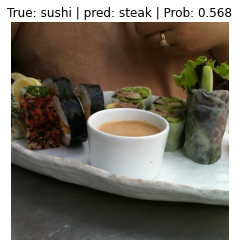

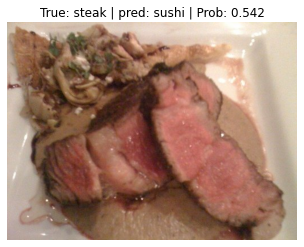

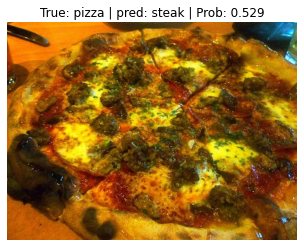

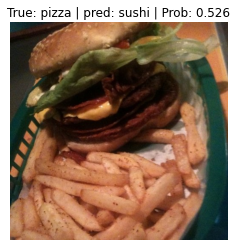

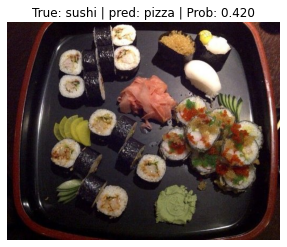

In [ ]:
for row in top_5_most_wrong.iterrows():
  row = row[1] # take 1 outof 5
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  #print(row)
  #break
  #plot
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1,2,0)) # matplot use [height, width, color channels]
  plt.title(f"True: {true_label} | pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

it's very import to figure out where your model predicted wrong with high prediction probability.
* this is very important for trobleshooting your model where model goes wrong.
* Ask question all the time and find the answer. Questin may be the following:

**Question:**

1. Predict on your own image of pizza/steak/sushi- how does the model go?
2. what happens if you predict on an image that isn't pizza/steak/sushi 

In [ ]:
#Predict on your own image of pizza/steak/sushi- how does the model go?
# download an image from unsplash.com and cp (copy this and rename it as pizza.jpg)
!wget https://images.unsplash.com/photo-1513104890138-7c749659a591
!cp photo-1513104890138-7c749659a591 pizza.jpg

In [ ]:
#make a function to pred and plot images
def pred_and_plot(image_path, model, transform,class_names, device = device):
  #open image
  image = Image.open(image_path)
  #transform image
  transformed_image = transform(image)
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim =1), dim =1)

  #plot iamge and pred
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

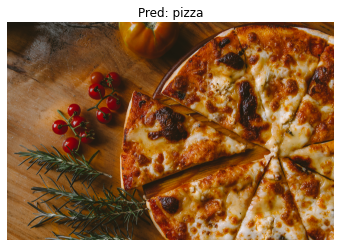

In [ ]:
pred_and_plot(image_path = "pizza.jpg",
              model = model_0,
              transform = simple_transform,
              class_names = class_names)

In [ ]:
# what happens if you predict on an image that isn't pizza/steak/sushi
#download an iamge from unsplace.co
!wget https://images.unsplash.com/photo-1568702846914-96b305d2aaeb
!cp photo-1568702846914-96b305d2aaeb apple.jpg

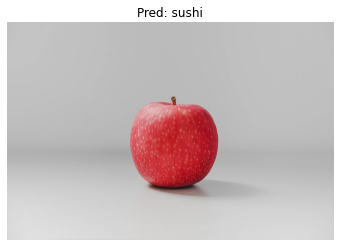

In [ ]:
#now call function fro prediction
pred_and_plot(image_path = "apple.jpg",
              model = model_0,
              transform = simple_transform,
              class_names = class_names)

In [ ]:
#check effnet_b0 results with 10% of data for 5 epoch
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8759469696969697, 0.4780218005180359)

**End of model_0 setupt**
model_0 = 10% data, effnet_b0 , 5 epochs

**Q. Train the model for 10 epochs and see what happens to the performance?**


In [ ]:
# recretee new model
import torchvision
model_1 = torchvision.models.efficientnet_b0(pretrained = True).to(device)
#model_1
# # Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False
# change the classification head
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2),
    nn.Linear(in_features = 1280, out_features = len(class_names), bias = True)
  ).to(device)
#model_1

Linear(in_features=1280, out_features = 3/1000)
what does it mean? in_features = 1280 in efficientnetbo
it means if you pass an image through efficientnetb0, it'g going to turn that single image into a feature vector of size 1280. basically it's crunching the numbers on whatever image goes through and turns it into a vector of 1280 long and say hes this is the representation that i have found from this image based on what i've learned from imagenet.
then above features vector compress into leangth of class names which is three (here- pizza, steak, sushi)


In [ ]:
# summary(model_1, 
#                   input_size = [32, 3, 224, 224],
#                   col_names =["input_size", "output_size", "trainable"])

In [ ]:
#create a new loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.001)

In [ ]:
#set the reandom seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#start the timer
from timeit import default_timer as timer
start_time = timer()
#setup training and save the results
model_1_results = engine.train(model = model_1,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 10,
                       device = device)
#end the timer and print out how long it took
end_time = timer()
print(f"[info] total training time : {end_time - start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2819 | train_acc: 0.9688 | test_loss: 0.3614 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.2900 | train_acc: 0.9727 | test_loss: 0.3480 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.2559 | train_acc: 0.9805 | test_loss: 0.3724 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.3290 | train_acc: 0.8633 | test_loss: 0.3764 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.2500 | train_acc: 0.9766 | test_loss: 0.4120 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.2643 | train_acc: 0.9805 | test_loss: 0.4038 | test_acc: 0.8144
Epoch: 7 | train_loss: 0.2589 | train_acc: 0.9727 | test_loss: 0.3802 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.2701 | train_acc: 0.9805 | test_loss: 0.3844 | test_acc: 0.8144
Epoch: 9 | train_loss: 0.3281 | train_acc: 0.8438 | test_loss: 0.3801 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.2872 | train_acc: 0.9688 | test_loss: 0.3436 | test_acc: 0.8864
[info] total training time :  28.778 seconds


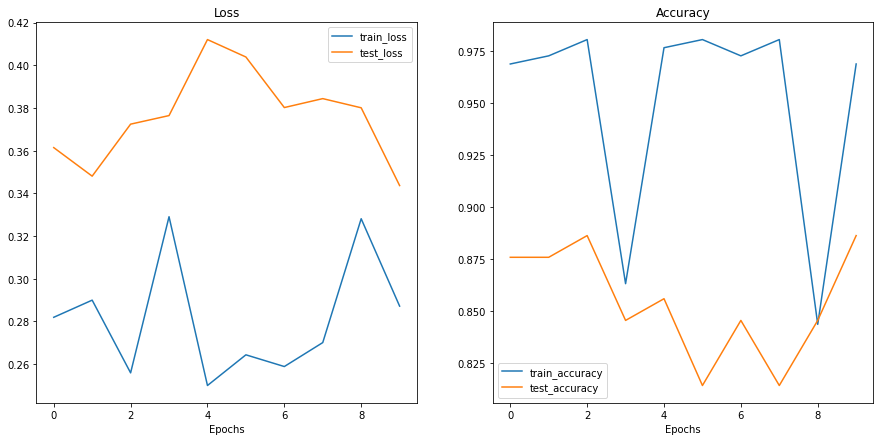

In [ ]:
#plot the loss code
from helper_functions import plot_loss_curves
plot_loss_curves(model_1_results)

**This is the end of model_1 setup:**
model_1 = 10% data, effnet_b0 , 10 epochs

**Question: whatif we trian model with more data?**
* train model with 20 perecent pizza_steak_sushi data

In [ ]:
#download more data, change the get data code again
#get data
import os
import zipfile
from pathlib import Path
import requests

data_path = Path("data/")
image_path = data_path /"pizza_steak_sushi_20_percent"
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one....")
  image_path.mkdir(parents=True, exist_ok = True)

  #Downloading pizza, steak, sushi data
  with open(image_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/zim10/Deep-learning-using-pytorch/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("downloading pizza, steak, sushi data....")
    f.write(request.content)
  #unzip
  with zipfile.ZipFile(image_path /"pizza_steak_sushi_20_percent.zip", "r" ) as zip_ref:
    print("unzipping")
    zip_ref.extractall(image_path)

# train_dir = image_path /"train"
# test_dir = image_path /"test"

Did not find data/pizza_steak_sushi_20_percent directory, creating one....
downloading pizza, steak, sushi data....
unzipping


In [ ]:
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"
train_dir_20_percent, test_dir_20_percent

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
#create dataloader
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
#create a train and test data loader using manual_transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir_20_percent,
                                                                               test_dir = test_dir_20_percent,
                                                                               transform = simple_transform,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f26d08e3880>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
len(train_dataloader), len(test_dataloader)

(15, 5)

In [ ]:
#create a new model for 20% of the data
model_2 = torchvision.models.efficientnet_b0(pretrained = True).to(device)
#model_2
# # Freeze the base layers
for param in model_2.features.parameters():
  param.requires_grad = False
# change the classification head
model_2.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2),
    nn.Linear(in_features = 1280, out_features = len(class_names), bias = True)
  ).to(device)
#model_2

In [ ]:
#train the model with 20 percent data
#create a new loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = 0.001)

In [ ]:
#set the reandom seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#start the timer
from timeit import default_timer as timer
start_time = timer()
#setup training and save the results
model_2_results = engine.train(model = model_2.to(device),
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)
#end the timer and print out how long it took
end_time = timer()
print(f"[info] total training time : {end_time - start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9753 | train_acc: 0.5917 | test_loss: 0.6958 | test_acc: 0.8699
Epoch: 2 | train_loss: 0.7083 | train_acc: 0.8396 | test_loss: 0.5368 | test_acc: 0.9068
Epoch: 3 | train_loss: 0.5784 | train_acc: 0.8667 | test_loss: 0.4581 | test_acc: 0.9125
Epoch: 4 | train_loss: 0.4489 | train_acc: 0.8875 | test_loss: 0.4129 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.4457 | train_acc: 0.8917 | test_loss: 0.3807 | test_acc: 0.9222
[info] total training time :  20.407 seconds


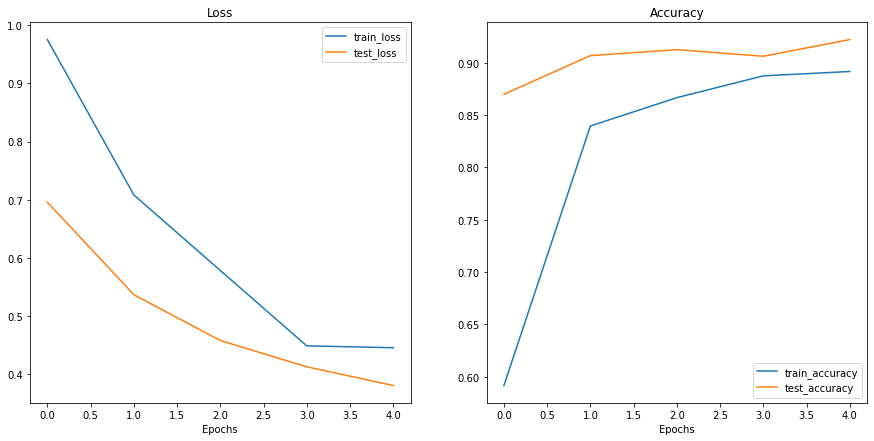

In [ ]:
#plot the loss code
from helper_functions import plot_loss_curves
plot_loss_curves(model_2_results)

**End of model_2 setup:**
model_2 = 20% data, effnet_b0 , 5 epochs

**Qurestion: try a different model from torchvision.models on the pizza, steak, sushi data and how does the model perform?**

* you have to change the size of the classifer layer to suit class label (pizza, steak, sushi)
* you can try a efficientNet with a higher number than B0, perhaps torchvision.models.efficientnet_b2()?

In [ ]:
#create a transform to transform the data
from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [ ]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [ ]:
#dataloader create
train_dir, test_dir
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                   test_dir = test_dir,
                                                                                                   transform = effnet_b2_transform,
                                                                                                   batch_size = 32)
len(train_dataloader_effnet_b2), len(test_dataloader_effnet_b2)


In [ ]:
# new model create using effnet_b2
#model_3 = torchvision.models.efficientnet_b2(pretrained = True) #old method
model_3 = torchvision.models.efficientnet_b2( weights='DEFAULT')
#model_3
#freee the base layers
for param in model_3.parameters():
  param.requires_grad = False
#change the classifier layer to your class (here 3 pizza, steak, sushi)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace = True),
    nn.Linear(in_features = 1408, out_features =len(class_names), bias = True)

).to(device)
#get a summary of the new model
summary(model_3,
        input_size = [32, 3, 288, 288],
        col_names = ["input_size", "output_size", "trainable"])




**Question: which one did the best?**

you can do the experiment with above model:
* model_0 = 10% data, effnet_b0 , 5 epochs
* model_1 = 10% data, effnet_b0, 10 epochs (double training time)
* model_2 = 20% data, effnet_b0, 5 epochs(double data)
* model_3 = 10% data, effnet_b2, 5 epochs(double model parameters)

In [ ]:
#train the model_3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr = 0.001)
#set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#start the timer
from timeit import default_timer as timer
start_time = timer()
#setup training and save the results
model_3_results = engine.train(model = model_3,
                               train_dataloader = train_dataloader_effnet_b2,
                               test_dataloader = test_dataloader_effnet_b2,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs =5, 
                               device =device)
#end the timer and print out how long it took
end_time = timer()
print(f"[info] totat training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1116 | train_acc: 0.3281 | test_loss: 0.9128 | test_acc: 0.7027
Epoch: 2 | train_loss: 0.8984 | train_acc: 0.6680 | test_loss: 0.8666 | test_acc: 0.8248
Epoch: 3 | train_loss: 0.8054 | train_acc: 0.7930 | test_loss: 0.7903 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7401 | train_acc: 0.7656 | test_loss: 0.6711 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6473 | train_acc: 0.8047 | test_loss: 0.6556 | test_acc: 0.8769
[info] totat training time: 13.652 seconds


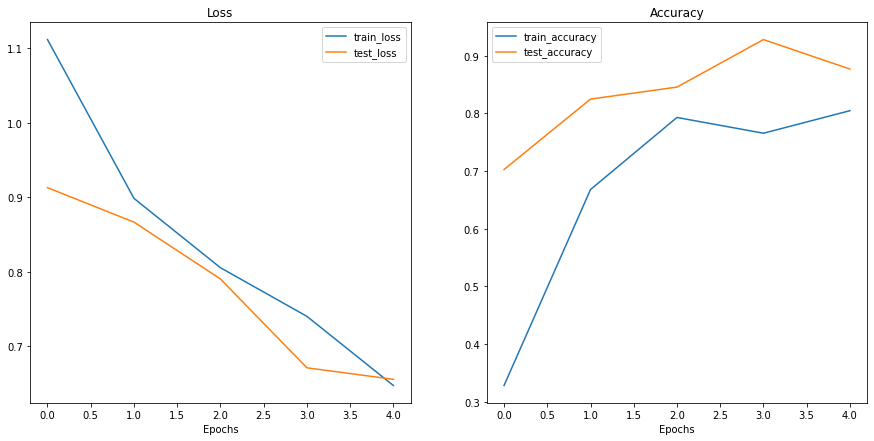

In [ ]:
#plot the loss code
from helper_functions import plot_loss_curves
plot_loss_curves(model_3_results)

**end of model_3 setup:**
model_3 = 10% data, effnet_b2, 5 epochs(double model parameters)

## Compare 4 model's result

In [ ]:
#check effnet_b0 results with 10% of data for 5 epoch
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8759469696969697, 0.4780218005180359)

In [ ]:
#check effnet_b0 results with 10% of data for 10 epoch (dobule training time)
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.8863636363636364, 0.34363192319869995)

In [ ]:
#check effnet_b0 results with 20% of data for 5 epoch (double data)
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.922159090909091, 0.3807243347167969)

In [ ]:
#check effnet_b2 results with 10% of data for 5 epoch (double model parameters)
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.9280303030303031, 0.6556313037872314)